# K-MEANS CLUSTERING

### PUNTI DA CHIARIRE:
##### - questione variables da mettere negli assi  --> chat dice che bisogna trovare le variabili che sono correlate tra di loro

In [313]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [314]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans
from sklearn.cluster import KMeans
#evaluation
from sklearn.metrics import silhouette_score

In [315]:
df = pd.read_csv("pp_train.csv")
df.head()

,originalTitle,rating,startYear,endYear,runtimeMinutes,awardWins,numVotes,worstRating,bestRating,totalImages,...,is_War,is_Sci-Fi,is_Talk-Show,is_Adventure,is_Film-Noir,is_Music,is_Western,is_Comedy,is_Drama,fill_runtimeMinutes
0,Neogenic Nightmare Chapter 3: Hydro-Man,8,1995,NaN,NaN,0.0,779,1,10,1,...,0,0,0,1,0,0,0,0,0,40.0
1,Looping,6,1982,NaN,NaN,0.0,11,1,10,1,...,0,0,0,0,0,0,0,0,0,28.0
2,Idealnaya para,6,1992,NaN,NaN,0.0,38,1,10,1,...,0,0,0,0,0,0,0,1,0,90.0
3,MasterChef Celebrity México,6,2021,NaN,NaN,0.0,15,1,10,22,...,0,0,0,0,0,0,0,0,0,31.0
4,Seutateueob,8,2020,2020.0,80.0,1.0,15718,1,10,347,...,0,0,0,0,0,0,0,1,1,80.0


In [316]:
df.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'worstRating', 'bestRating', 'totalImages',
       'totalVideos', 'totalCredits', 'criticReviewsTotal', 'titleType',
       'awardNominationsExcludeWins', 'canHaveEpisodes', 'isRatable',
       'isAdult', 'numRegions', 'userReviewsTotal', 'ratingCount',
       'countryOfOrigin', 'is_Thriller', 'is_Family', 'is_Short', 'is_Sport',
       'is_Biography', 'is_Musical', 'is_Game-Show', 'is_Crime', 'is_Mystery',
       'is_Horror', 'is_Romance', 'is_Animation', 'is_Fantasy', 'is_Action',
       'is_Documentary', 'is_News', 'is_History', 'is_Adult', 'is_Reality-TV',
       'is_War', 'is_Sci-Fi', 'is_Talk-Show', 'is_Adventure', 'is_Film-Noir',
       'is_Music', 'is_Western', 'is_Comedy', 'is_Drama',
       'fill_runtimeMinutes'],
      dtype='object')

#### definizione delle feature da usare per clustering

In [317]:
#features = df[['fill_runtimeMinutes', "numVotes"]]
features = df[["awardWins", "numVotes", "worstRating", "bestRating", "totalImages", "totalVideos", "totalCredits", "criticReviewsTotal", "awardNominationsExcludeWins", "numRegions", "userReviewsTotal", "ratingCount", "fill_runtimeMinutes"]]
X = features.values

#### mapping della variabile target (per noi è titleType) così da confrontarla dopo con gli eventuali cluster/individuare quali cluster contengono un'alta percentuale di quale categoria di titleType

In [318]:
y = np.array(df['titleType'])
y_map = {"tvEpisode": 0, "videoGame": 1, "movie": 2, "tvSeries": 3, "video": 4,
         "tvMiniSeries": 5, "short": 6, "tvMovie": 7, "tvSpecial": 8, "tvShort": 9}

y_mapped = pd.DataFrame(y).iloc[:,0].map(y_map) #target label

### normalizzazione con z-score e minmax

In [319]:
scaler = StandardScaler() 
scaler.fit(X) #x è la numpy matrix of the dataset
X_scal = scaler.transform(X)

In [320]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

### inizializzazione modello

In [321]:
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=100, random_state=94) #inizializziamo algoritmo, fit it per lavorare sull'exact data
#iniziamo con 3 cluster, 10 iterations, random_state: allows to have the same result 

kmeans.fit(X_scal)
#kmeans.fit(X_minmax)

KMeans(max_iter=100, n_clusters=3, n_init=10, random_state=94)

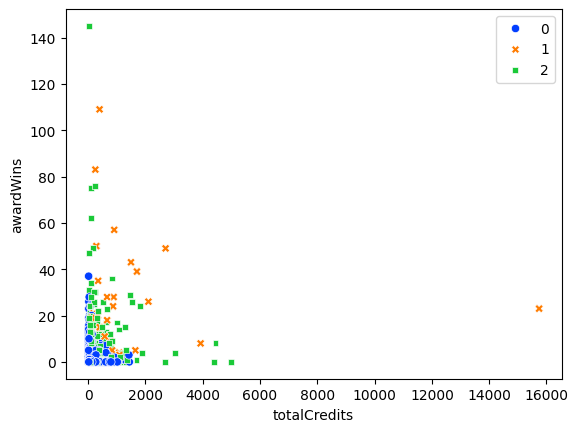

In [322]:
sns.scatterplot(data=df, 
                x="totalCredits",
                y="awardWins",
                hue=kmeans.labels_,
                style=kmeans.labels_, #usiamo labels date da k-means
                palette="bright")
plt.show()

### identificazione dei centroidi

In [323]:
kmeans.cluster_centers_ #coordinates with centroids

array([[-0.06182127, -0.06257704,  0.        ,  0.        , -0.06948972,
        -0.05221752, -0.05826208, -0.10939638, -0.07339328, -0.13557836,
        -0.07356613, -0.06258049, -0.03083587],
       [ 7.85816862, 17.00743536,  0.        ,  0.        ,  6.15128467,
         6.68932576,  6.74373213, 13.60456862, 11.36239229,  7.71595709,
        13.90601087, 17.00746602,  1.04819286],
       [ 1.35419758,  0.73913407,  0.        ,  0.        ,  1.70926552,
         1.14020602,  1.322421  ,  2.41732697,  1.46582506,  3.6338651 ,
         1.2936826 ,  0.73923816,  0.87579033]])

In [324]:
centers = scaler.inverse_transform(kmeans.cluster_centers_) #from normalized to input domain
centers

array([[-8.96408486e+00, -6.04794658e+04,  1.00000000e+00,
         1.00000000e+01, -2.43491978e+02, -1.34721207e+01,
        -9.17161686e+02, -5.83082729e+01, -1.44584757e+01,
        -8.21932878e+00, -4.21313238e+02, -6.05126533e+04,
        -9.25076050e+01],
       [ 1.13943445e+03,  1.64387117e+07,  1.00000000e+00,
         1.00000000e+01,  2.15541015e+04,  1.72584605e+03,
         1.06159831e+05,  7.25123507e+03,  2.23839128e+03,
         5.25685082e+02,  7.96397243e+04,  1.64468539e+07,
         3.14457858e+03],
       [ 1.96358650e+02,  7.14422423e+05,  1.00000000e+00,
         1.00000000e+01,  5.98926639e+03,  2.94173152e+02,
         2.08175513e+04,  1.28843528e+03,  2.88767537e+02,
         2.48102827e+02,  7.40892023e+03,  7.14875652e+05,
         2.62737099e+03]])

In [325]:
df['kmeans_labels'] = kmeans.labels_
df['kmeans_labels'] = df['kmeans_labels'].map({0:"A", 1: "B", 2: "C"})

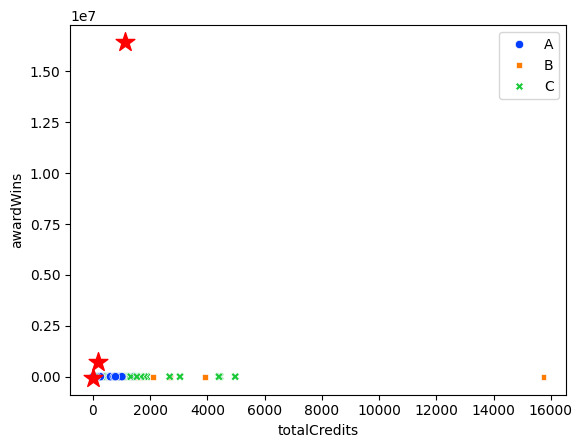

In [ ]:
sns.scatterplot(data=df, 
                x="totalCredits", 
                y="awardWins", 
                hue='kmeans_labels', 
                style='kmeans_labels',
                palette="bright", 
                hue_order=["A", "B", "C"]
               )
plt.legend()
#qui è giusto che centers sia :,1 se in quello di fedele dice [:,2]?
plt.scatter(centers[:,0], centers[:,2], c='red', marker='*', s=200) #plotting the centroids
plt.show()

### conronto con target variable

In [327]:
y_mapped

0        0
1        1
2        2
3        3
4        3
        ..
16426    2
16427    2
16428    2
16429    2
16430    6
Name: 0, Length: 16431, dtype: int64

In [328]:
y_mapped.groupby(df['kmeans_labels']).value_counts(normalize=True)

kmeans_labels  0
A              0    0.295862
               1    0.015996
C              1    0.009690
B              2    0.805556
C              2    0.767442
A              2    0.321809
B              3    0.194444
C              3    0.180233
A              3    0.080295
               4    0.049373
C              4    0.015504
A              5    0.013666
C              5    0.013566
A              6    0.155614
C              6    0.005814
A              7    0.054411
C              7    0.007752
A              8    0.010454
               9    0.002519
Name: proportion, dtype: float64

### metrics

In [329]:
print('SSE', kmeans.inertia_)
print('Silhouette', silhouette_score(X_minmax, kmeans.labels_))

SSE 114810.8720081443
Silhouette 0.8311440591645148


In [330]:
%%time
sse_list = []

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax)
    sse_list.append(kmeans.inertia_)

CPU times: total: 7.02 s
Wall time: 19.9 s


In [ ]:
sil_list = []

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax)
    sil_list.append(silhouette_score(X_minmax, kmeans.labels_))

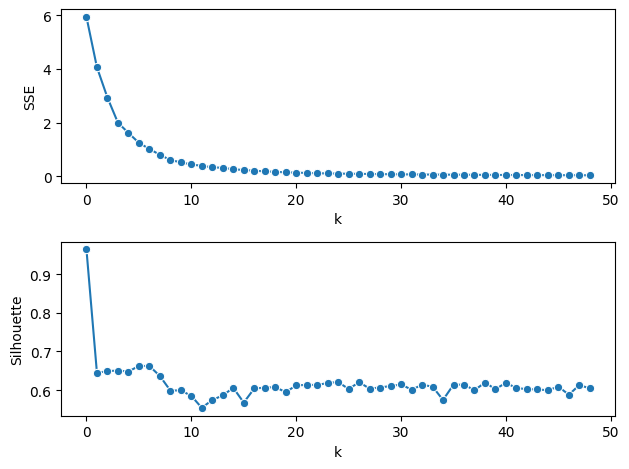

In [264]:
fig, axs = plt.subplots(2) 

sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o', ax=axs[0])
axs[0].set(xlabel='k', ylabel='SSE')

sns.lineplot(x=range(len(sil_list)), y=sil_list, marker='o', ax=axs[1])
axs[1].set(xlabel='k', ylabel='Silhouette')

plt.tight_layout()